# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Frameworks</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## Lab - Batch Normalization com MXNet

Em Machine Learning em geral, é muito comum normalizarmos a camada de entrada ajustando e dimensionando os dados. 

Por exemplo, quando temos atributos (variáveis) com valores de 0 a 1 e alguns de 1 a 1000, devemos normalizá-los para acelerar o aprendizado (colocar todos os dados na mesma escala). Se a camada de entrada está se beneficiando da normalização, por que não fazer o mesmo com os valores nas camadas ocultas, que mudam o tempo todo? Ao fazer isso, poderíamos obter 10 vezes ou mais melhorias na velocidade de treinamento.

A normalização em lotes reduz a quantidade pela qual os valores das unidades ocultas mudam (mudança de covariância). Para explicar a mudança de covariância, considere como exemplo uma rede profunda para detecção de gatos. Treinamos nossos dados apenas nas imagens de gatos pretos. Portanto, se agora tentarmos aplicar essa rede a dados com gatos coloridos, não vamos nos sair bem. O conjunto de treinamento e o conjunto de previsão são imagens de gatos, mas diferem um pouco. Em outras palavras, se um algoritmo aprendeu algum mapeamento de X para Y e se a distribuição de X mudar, talvez seja necessário treinar novamente o modelo, tentando alinhar a distribuição de X com a distribuição de Y.

Além disso, a normalização em lote permite que cada camada de uma rede aprenda sozinha um pouco mais independentemente de outras camadas.

Ao usar Batch Normalization, podemos usar taxas de aprendizado mais altas porque a normalização em lote garante que não haja ativação muito alta ou muito baixa. 

Batch Normalization também reduz a adaptação excessiva (overfitting), porque apresenta alguns efeitos de regularização. Semelhante ao Dropout, essa técnica adiciona algum ruído às ativações de cada camada oculta. Portanto, se usarmos a normalização em lote, usaremos menos dropouts, o que é uma coisa boa, pois não perderemos muitas informações. No entanto, não devemos depender apenas da normalização de lotes para regularização; devemos usá-lo em conjunto com o Dropout.

É o que faremos agora neste Lab.

Referências:

<a href="https://arxiv.org/pdf/1502.03167v3.pdf">Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</a>

<a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>

In [2]:
!nvidia-smi

Fri May 22 13:08:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0  On |                  N/A |
| 24%   42C    P8    11W / 250W |     94MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   37C    P8    10W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Instala o pacote MXNet com suporte a GPU
!pip install -q mxnet-cu102

In [5]:
# Imports
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, data
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

mxnet      1.6.0
matplotlib 3.2.1
Data Science Academy


In [7]:
# Faremos o treinamento em GPU
ctx = mx.gpu()

### Carregando o Dataset

Criaremos um modelo de Deep Learning para classificação de imagens usando o dataset CIFAR10.

In [8]:
# Função para transformar os dados
def transform(data, label):
    return nd.moveaxis(data.astype('float32'), 2, 0)/255.0, label.astype('float32')

In [9]:
# Carrega os dados de treino
cifar_treino = data.vision.datasets.CIFAR10(train = True, transform = transform)

In [10]:
# Carrega os dados de teste
cifar_teste = data.vision.datasets.CIFAR10(train = False, transform = transform)

In [11]:
# Extrai uma imagem
image, label = cifar_treino[456]

In [12]:
# Shape da imagem
image.shape

(3, 32, 32)

In [13]:
# Shape do label
label.shape

()

### Definindo o DataLoader

O DataLoader extrai batches de dados para alimentar o modelo durante o treinamento.

In [14]:
# Tamanho do batch
batch_size = 128

In [15]:
# Carrega os batches de treino e teste
dados_treino = data.DataLoader(cifar_treino, batch_size, True)
dados_teste = data.DataLoader(cifar_teste, batch_size, False)

### Construindo o Modelo

Agora construímos o modelo de rede neural para classificação de imagens usando Batch Normalization.

Observe que o Batch Normalization deve vir antes do Dropout.

In [16]:
# Cria o modelo
model = nn.Sequential()

# Primeira camada convolucional com Batch Normalization
model.add(nn.Conv2D(channels = 16, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

# Segunda camada convolucional com Batch Normalization
model.add(nn.Conv2D(channels = 32, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

# Terceira camada convolucional com Batch Normalization
model.add(nn.Conv2D(channels = 64, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

# Flatten
model.add(nn.Flatten())

# Camada Densa com Batch Normalization
model.add(nn.Dense(512))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.Dropout(0.5))

# Camada Densa com Batch Normalization
model.add(nn.Dense(256))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.Dropout(0.5))

# Camada de saída
model.add(nn.Dense(10))

In [17]:
# Inicializa os hiperpaâmetros
model.initialize(mx.init.Xavier(), ctx)

In [18]:
# Modelo criado
model

Sequential(
  (0): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Conv2D(None -> 32, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (6): Activation(relu)
  (7): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (8): Conv2D(None -> 64, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): Activation(relu)
  (11): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (12): Flatten
  (13): Dense

Vamos verificar um sumário completo.

In [19]:
# Sumário do modelo
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 16, 28, 28)            1216
         BatchNorm-2                             (1, 16, 28, 28)              64
        Activation-3                             (1, 16, 28, 28)               0
         MaxPool2D-4                             (1, 16, 27, 27)               0
            Conv2D-5                             (1, 32, 23, 23)           12832
         BatchNorm-6                             (1, 32, 23, 23)             128
        Activation-7                             (1, 32, 23, 23)               0
         MaxPool2D-8                             (1, 32, 22, 22)               0
            Conv2D-9                             (1, 64, 18, 18)           51264
        BatchNorm-10        

Precisamos de uma função de custo e usaremos a SoftmaxCrossEntropyLoss.

In [20]:
# Função de custo
objective = gluon.loss.SoftmaxCrossEntropyLoss()

E também precisamos de um otimizador para atualizar os pesos a cada passada.

In [21]:
# Otimizador
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

Por fim, usaremos a acurácia como métrica de avaliação do modelo.

In [22]:
# Métrica do modelo
metric = mx.metric.Accuracy()

### Treinamento do Modelo

Agora treinamos o modelo.

In [23]:
# Número de épocas e listas para erros e acurácias em cada época
epochs = 10
losses = []
accs = []

In [24]:
# Loop de treinamento

print("\nIniciando o Treinamento...\n")

for epoch in range(epochs):
    
    # Inicializa o erro acumulado
    cumulative_loss = 0
    
    # Reset da métrica
    metric.reset()
    
    # Loop pelos batches de dados
    for batches, (features, labels) in enumerate(dados_treino, 1):
        
        # Envia dados de entrada e saída para a GPU
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        # Executa a previsão do modelo e calcula o erro
        with autograd.record():
            output = model(features)
            loss = objective(output, labels)
            
        # Inicia o backpropagation
        loss.backward()
        
        # Atualiza os pesos para a próxima passada de treino
        optimizer.step(batch_size)
        
        # Acumula o erro médio
        cumulative_loss += loss.mean()
        
        # Calcula a métrica
        metric.update(labels, output)
        
    # Extrai a acurácia    
    acc = metric.get()[1]
    
    # Alimenta as listas de erro e acurácias
    losses.append(cumulative_loss.asscalar())
    accs.append(acc)
    
    # print
    print(f'Epoch: {epoch} | Erro: {cumulative_loss.asscalar()/(batches):.5f} | Acurácia: {acc:.5f}')

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento...

Epoch: 0 | Erro: 1.57516 | Acurácia: 0.44366
Epoch: 1 | Erro: 1.14906 | Acurácia: 0.59536
Epoch: 2 | Erro: 0.99285 | Acurácia: 0.64974
Epoch: 3 | Erro: 0.89722 | Acurácia: 0.68222
Epoch: 4 | Erro: 0.81835 | Acurácia: 0.71292
Epoch: 5 | Erro: 0.76283 | Acurácia: 0.73570
Epoch: 6 | Erro: 0.70010 | Acurácia: 0.75354
Epoch: 7 | Erro: 0.66138 | Acurácia: 0.76854
Epoch: 8 | Erro: 0.61049 | Acurácia: 0.78570
Epoch: 9 | Erro: 0.56233 | Acurácia: 0.80210

Treinamento Concluído.



### Avaliando o Modelo

In [25]:
# Zeramos a métrica
metric.reset()

In [26]:
# Loop para previsões nos dados de teste
for features, labels in dados_teste:
    features = features.as_in_context(mx.gpu())
    labels = labels.as_in_context(mx.gpu())
    predictions = model(features)
    metric.update(labels, predictions)

In [27]:
print(f'Acurácia em Teste: {metric.get()[1]:.5f}')

Acurácia em Teste: 0.70980


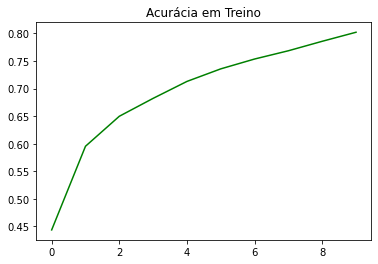

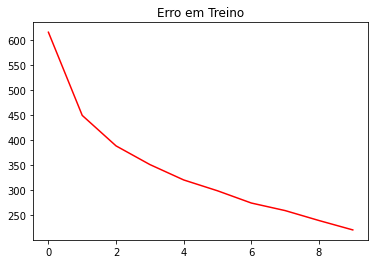

In [28]:
# Plots
plt.plot(accs, c = 'g')
plt.title('Acurácia em Treino')
plt.show()

plt.plot(losses, c = 'r')
plt.title('Erro em Treino')
plt.show()

Batch Normalization podem ser uma boa opção quando precisarmos aumentar a precisão do nosso modelo, reduzindo o risco de overfitting.

# Fim